# SIT model equation

Code by [Maziar Raissi](https://github.com/maziarraissi/DeepHPMs/blob/master/Codes/Schrodinger.py), translated to this notebook with the gol of learning the method.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from pyDOE import lhs
import time
#from plotting import newfig, savefig
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import scipy.io
mat = scipy.io.loadmat('data/NLS.mat')

In [3]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Jan 18 03:18:22 2018',
 '__version__': '1.0',
 '__globals__': [],
 't': array([[0.        , 0.00314159, 0.00628319, 0.00942478, 0.01256637,
         0.01570796, 0.01884956, 0.02199115, 0.02513274, 0.02827433,
         0.03141593, 0.03455752, 0.03769911, 0.0408407 , 0.0439823 ,
         0.04712389, 0.05026548, 0.05340708, 0.05654867, 0.05969026,
         0.06283185, 0.06597345, 0.06911504, 0.07225663, 0.07539822,
         0.07853982, 0.08168141, 0.084823  , 0.08796459, 0.09110619,
         0.09424778, 0.09738937, 0.10053096, 0.10367256, 0.10681415,
         0.10995574, 0.11309734, 0.11623893, 0.11938052, 0.12252211,
         0.12566371, 0.1288053 , 0.13194689, 0.13508848, 0.13823008,
         0.14137167, 0.14451326, 0.14765485, 0.15079645, 0.15393804,
         0.15707963, 0.16022123, 0.16336282, 0.16650441, 0.169646  ,
         0.1727876 , 0.17592919, 0.17907078, 0.18221237, 0.18535397,
         0.18849556, 0.19163

## Helper functions:

In [4]:
def initialize_NN(layers):
    weights = []
    biases = []
    num_layers = len(layers) 
    for l in range(0,num_layers-1):
        W = xavier_init(size=[layers[l], layers[l+1]])
        b = tf.Variable(tf.zeros([1,layers[l+1]]), dtype=tf.float32)
        weights.append(W)
        biases.append(b)        
    return weights, biases

In [5]:
def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]        
    xavier_stddev = np.sqrt(2/(in_dim + out_dim))
    return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

In [6]:
def neural_net(X, weights, biases):
    num_layers = len(weights) + 1
    H = X
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.sin(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y

##  DeepHPM Class

In [ ]:
###############################################################################
################################ DeepHPM Class ################################
###############################################################################


class DeepHPM:    
    def __init__(self, t, x, y, u, v, w,
                       t_b, x_b, y_b, w_b,
                       t_f, x_f, y_f, u_f, v_f,
                       w_layers, pde_layers,
                       layers,
                       lb, ub):
        
        # Domain Boundary
        self.lb = lb
        self.ub = ub
        
        # Init for Identification
        self.idn_init(t, x, y, u, v, w, w_layers, pde_layers)
        
        # Init for Solution
        self.sol_init(t_b, x_b, y_b, w_b,
                      t_f, x_f, y_f, u_f, v_f, layers)
            
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
    
    ###########################################################################
    ############################# Identifier ##################################
    ###########################################################################
        
    def idn_init(self, t, x, y, u, v, w, w_layers, pde_layers):
        # Training Data for Identification
        self.t = t
        self.x = x
        self.y = y
        self.u = u
        self.v = v
        self.w = w
        
        # Layers for Identification
        self.w_layers = w_layers
        self.pde_layers = pde_layers
        
        # Initialize NNs for Identification
        self.w_weights, self.w_biases = initialize_NN(w_layers)
        self.pde_weights, self.pde_biases = initialize_NN(pde_layers)
        
        # tf placeholders for Identification
        self.t_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.v_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.w_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.terms_tf = tf.placeholder(tf.float32, shape=[None, pde_layers[0]])
        
        # tf graphs for Identification
        self.idn_w_pred = self.idn_net_w(self.t_tf, self.x_tf, self.y_tf)
        self.pde_pred = self.net_pde(self.terms_tf)
        self.idn_f_pred = self.idn_net_f(self.t_tf, self.x_tf, self.y_tf, self.u_tf, self.v_tf)
        
        # loss for Identification
        self.idn_w_loss = tf.reduce_sum(tf.square(self.idn_w_pred - self.w_tf))
        self.idn_f_loss = tf.reduce_sum(tf.square(self.idn_f_pred))
        
        # Optimizer for Identification
        self.idn_w_optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.idn_w_loss,
                               var_list = self.w_weights + self.w_biases,
                               method = 'L-BFGS-B',
                               options = {'maxiter': 50000,
                                          'maxfun': 50000,
                                          'maxcor': 50,
                                          'maxls': 50,
                                          'ftol': 1.0*np.finfo(float).eps})
    
        self.idn_f_optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.idn_f_loss,
                               var_list = self.pde_weights + self.pde_biases,
                               method = 'L-BFGS-B',
                               options = {'maxiter': 50000,
                                          'maxfun': 50000,
                                          'maxcor': 50,
                                          'maxls': 50,
                                          'ftol': 1.0*np.finfo(float).eps})
    
        self.idn_w_optimizer_Adam = tf.train.AdamOptimizer()
        self.idn_w_train_op_Adam = self.idn_w_optimizer_Adam.minimize(self.idn_w_loss, 
                                   var_list = self.w_weights + self.w_biases)
        
        self.idn_f_optimizer_Adam = tf.train.AdamOptimizer()
        self.idn_f_train_op_Adam = self.idn_f_optimizer_Adam.minimize(self.idn_f_loss, 
                                   var_list = self.pde_weights + self.pde_biases)  
    
    def idn_net_w(self, t, x, y):
        X = tf.concat([t,x,y],1)
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        w = neural_net(H, self.w_weights, self.w_biases)
        return w
    
    def net_pde(self, terms):
        pde = neural_net(terms, self.pde_weights, self.pde_biases)
        return pde
    
    def idn_net_f(self, t, x, y, u, v):
        w = self.idn_net_w(t, x, y)
        
        w_t = tf.gradients(w, t)[0]
        
        w_x = tf.gradients(w, x)[0]
        w_y = tf.gradients(w, y)[0]
        w_xx = tf.gradients(w_x, x)[0]
        w_xy = tf.gradients(w_x, y)[0]
        w_yy = tf.gradients(w_y, y)[0]
        
        terms = tf.concat([u,v,w,w_x,w_y,w_xx,w_xy,w_yy],1)
        
        f = w_t - self.net_pde(terms)
        
        return f

    def idn_w_train(self, N_iter):
        tf_dict = {self.t_tf: self.t, self.x_tf: self.x, self.y_tf: self.y,
                   self.u_tf: self.u, self.v_tf: self.v, self.w_tf: self.w}
        
        start_time = time.time()
        for it in range(N_iter):
            
            self.sess.run(self.idn_w_train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.idn_w_loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
        
        self.idn_w_optimizer.minimize(self.sess,
                                      feed_dict = tf_dict,
                                      fetches = [self.idn_w_loss],
                                      loss_callback = self.callback)

    def idn_f_train(self, N_iter):
        tf_dict = {self.t_tf: self.t, self.x_tf: self.x, self.y_tf: self.y,
                   self.u_tf: self.u, self.v_tf: self.v}
        
        start_time = time.time()
        for it in range(N_iter):
            
            self.sess.run(self.idn_f_train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.idn_f_loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
        
        self.idn_f_optimizer.minimize(self.sess,
                                      feed_dict = tf_dict,
                                      fetches = [self.idn_f_loss],
                                      loss_callback = self.callback)

    def idn_predict(self, t_star, x_star, y_star):
        
        tf_dict = {self.t_tf: t_star, self.x_tf: x_star, self.y_tf: y_star}
        
        w_star = self.sess.run(self.idn_w_pred, tf_dict)
        
        return w_star
    
    def predict_pde(self, terms_star):
        
        tf_dict = {self.terms_tf: terms_star}
        
        pde_star = self.sess.run(self.pde_pred, tf_dict)
        
        return pde_star
    
    ###########################################################################
    ############################### Solver ####################################
    ###########################################################################
    
    def sol_init(self, t_b, x_b, y_b, w_b,
                       t_f, x_f, y_f, u_f, v_f, layers):
        
        # Training Data for Solution
        self.t_b = t_b # initial and boundary data (time)
        self.x_b = x_b # initial and boundary data (space - x)
        self.y_b = y_b # initial and boundary data (space - y)
        self.w_b = w_b # boundary data (vorticity)
        
        self.t_f = t_f # collocation points (time)
        self.x_f = x_f # collocation points (space - x)
        self.y_f = y_f # collocation points (space - y)
        self.u_f = u_f # collocation points (space - u)
        self.v_f = v_f # collocation points (space - v)
        
        # Layers for Solution
        # self.layers = layers
        
        # Initialize NNs for Solution
        # self.weights, self.biases = initialize_NN(layers)
        
        # tf placeholders for Solution
        self.t_b_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_b_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_b_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.w_b_tf = tf.placeholder(tf.float32, shape=[None, 1])
        
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_f_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_f_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.v_f_tf = tf.placeholder(tf.float32, shape=[None, 1])
        
        # tf graphs for Solution
        self.w_b_pred  = self.sol_net_w(self.t_b_tf, self.x_b_tf, self.y_b_tf)
        self.sol_f_pred = self.sol_net_f(self.t_f_tf, self.x_f_tf, self.y_f_tf, self.u_f_tf, self.v_f_tf)
        
        # loss for Solution
        self.sol_loss = tf.reduce_sum(tf.square(self.w_b_tf - self.w_b_pred)) + \
                        tf.reduce_sum(tf.square(self.sol_f_pred))
        
        # Optimizer for Solution
        self.sol_optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.sol_loss,
                             var_list = self.w_weights + self.w_biases,
                             method = 'L-BFGS-B',
                             options = {'maxiter': 50000,
                                        'maxfun': 50000,
                                        'maxcor': 50,
                                        'maxls': 50,
                                        'ftol': 1.0*np.finfo(float).eps})
    
        self.sol_optimizer_Adam = tf.train.AdamOptimizer()
        self.sol_train_op_Adam = self.sol_optimizer_Adam.minimize(self.sol_loss,
                                 var_list = self.w_weights + self.w_biases)
    
    def sol_net_w(self, t, x, y):
        X = tf.concat([t,x,y],1)
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        w = neural_net(H, self.w_weights, self.w_biases)
        return w
    
    def sol_net_f(self, t, x, y, u, v):
        w = self.sol_net_w(t, x, y)
        
        w_t = tf.gradients(w, t)[0]
        
        w_x = tf.gradients(w, x)[0]
        w_y = tf.gradients(w, y)[0]
        
        w_xx = tf.gradients(w_x, x)[0]
        w_xy = tf.gradients(w_x, y)[0]
        w_yy = tf.gradients(w_y, y)[0]
        
        terms = tf.concat([u,v,w,w_x,w_y,w_xx,w_xy,w_yy],1)
        
        f = w_t - self.net_pde(terms)
        
        return f
    
    def callback(self, loss):
        print('Loss: %e' % (loss))
        
    def sol_train(self, N_iter):
        tf_dict = {self.t_b_tf: self.t_b,
                   self.x_b_tf: self.x_b,
                   self.y_b_tf: self.y_b,
                   self.w_b_tf: self.w_b,
                   self.t_f_tf: self.t_f,
                   self.x_f_tf: self.x_f,
                   self.y_f_tf: self.y_f,
                   self.u_f_tf: self.u_f,
                   self.v_f_tf: self.v_f}
        
        start_time = time.time()
        for it in range(N_iter):
            
            self.sess.run(self.sol_train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.sol_loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                
        self.sol_optimizer.minimize(self.sess, 
                                    feed_dict = tf_dict,         
                                    fetches = [self.sol_loss], 
                                    loss_callback = self.callback)
    
    def sol_predict(self, t_star, x_star, y_star):
        
        u_star = self.sess.run(self.w_b_pred, {self.t_b_tf: t_star, self.x_b_tf: x_star, self.y_b_tf: y_star})  
               
        return u_star

In [17]:
###############################################################################
################################ Main Function ################################
###############################################################################

if __name__ == "__main__": 
    
    # Doman bounds
    lb_idn = np.array([0.0, -5.0])
    ub_idn = np.array([np.pi/2, 5.0])
    
    lb_sol = np.array([0.0, -5.0])
    ub_sol = np.array([np.pi/2, 5.0])
    
    ### Load Data ###
    
    data_idn = scipy.io.loadmat('data/NLS.mat')
    
    t_idn = data_idn['t'].flatten()[:,None]
    x_idn = data_idn['x'].flatten()[:,None]
    Exact_u_idn = np.real(data_idn['usol'])
    Exact_v_idn = np.imag(data_idn['usol'])
    
    T_idn, X_idn = np.meshgrid(t_idn,x_idn)
    
    keep = 1
    index = int(keep*t_idn.shape[0])
    T_idn = T_idn[:,0:index]
    X_idn = X_idn[:,0:index]
    Exact_u_idn = Exact_u_idn[:,0:index]
    Exact_v_idn = Exact_v_idn[:,0:index]
    Exact_uv_idn = np.sqrt(Exact_u_idn**2 + Exact_v_idn**2)    
    
    t_idn_star = T_idn.flatten()[:,None]
    x_idn_star = X_idn.flatten()[:,None]
    X_idn_star = np.hstack((t_idn_star, x_idn_star))
    u_idn_star = Exact_u_idn.flatten()[:,None]
    v_idn_star = Exact_v_idn.flatten()[:,None]
    
    #
    
    data_sol = scipy.io.loadmat('data/NLS.mat')
    
    t_sol = data_sol['t'].flatten()[:,None]
    x_sol = data_sol['x'].flatten()[:,None]
    Exact_u_sol = np.real(data_sol['usol'])
    Exact_v_sol = np.imag(data_sol['usol'])
    Exact_uv_sol = np.sqrt(Exact_u_sol**2 + Exact_v_sol**2)
    
    T_sol, X_sol = np.meshgrid(t_sol,x_sol)
    
    t_sol_star = T_sol.flatten()[:,None]
    x_sol_star = X_sol.flatten()[:,None]
    X_sol_star = np.hstack((t_sol_star, x_sol_star))
    u_sol_star = Exact_u_sol.flatten()[:,None]
    v_sol_star = Exact_v_sol.flatten()[:,None]
    
    ### Training Data ###
    
    # For identification
    N_train = 10
    
    idx = np.random.choice(t_idn_star.shape[0], N_train, replace=False)    
    t_train = t_idn_star[idx,:]
    x_train = x_idn_star[idx,:]
    u_train = u_idn_star[idx,:]
    v_train = v_idn_star[idx,:]
    
    noise = 0.00
    u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
    v_train = v_train + noise*np.std(v_train)*np.random.randn(v_train.shape[0], v_train.shape[1])
    
    # For solution
    N0 = Exact_u_sol.shape[0]
    N_b = Exact_u_sol.shape[1]
    N_f = 20
        
    idx_x = np.random.choice(x_sol.shape[0], N0, replace=False)
    x0_train = x_sol[idx_x,:]
    u0_train = Exact_u_sol[idx_x,0:1]
    v0_train = Exact_v_sol[idx_x,0:1]
    
    idx_t = np.random.choice(t_sol.shape[0], N_b, replace=False)
    tb_train = t_sol[idx_t,:]
    
    X_f_train = lb_sol + (ub_sol-lb_sol)*lhs(2, N_f)
        
    # Layers
    uv_layers = [2, 50, 50, 50, 50, 1]
    pde_layers = [6, 100, 100, 1]
    
    layers = [2, 50, 50, 50, 50, 1]
    
    # Model
    model = DeepHPM(t_train, x_train, u_train, v_train,
                    x0_train, u0_train, v0_train, tb_train, X_f_train,
                    uv_layers, pde_layers,
                    layers,
                    lb_idn, ub_idn,
                    lb_sol, ub_sol)
    
    # Train the identifier
    model.idn_uv_train(N_iter=0)
        
    model.idn_fg_train(N_iter=0)
    
    u_pred_identifier, v_pred_identifier, f_pred_identifier, g_pred_identifier = model.idn_predict(t_idn_star, x_idn_star)
    
    error_u_identifier = np.linalg.norm(u_idn_star-u_pred_identifier,2)/np.linalg.norm(u_idn_star,2)
    error_v_identifier = np.linalg.norm(v_idn_star-v_pred_identifier,2)/np.linalg.norm(v_idn_star,2)
    print('Error u: %e' % (error_u_identifier))
    print('Error v: %e' % (error_v_identifier))
    
    ### Solution ###
    
    # Train the solver
    model.sol_train(N_iter=0)
        
    u_pred, v_pred, f_pred, g_pred = model.sol_predict(t_sol_star, x_sol_star)
    
    u_pred_idn, v_pred_idn, f_pred_idn, g_pred_idn = model.sol_predict(t_idn_star, x_idn_star)
    
    uv_pred = np.sqrt(u_pred**2 + v_pred**2)
    uv_sol_star = np.sqrt(u_sol_star**2 + v_sol_star**2)
    error_u = np.linalg.norm(u_sol_star-u_pred,2)/np.linalg.norm(u_sol_star,2)
    error_v = np.linalg.norm(v_sol_star-v_pred,2)/np.linalg.norm(v_sol_star,2)
    error_uv = np.linalg.norm(uv_sol_star-uv_pred,2)/np.linalg.norm(uv_sol_star,2)
    print('Error uv: %e' % (error_uv))
    
    error_u_idn = np.linalg.norm(u_idn_star-u_pred_idn,2)/np.linalg.norm(u_idn_star,2)
    error_v_idn = np.linalg.norm(v_idn_star-v_pred_idn,2)/np.linalg.norm(v_idn_star,2)
    
    print('Error u: %e' % (error_u))
    print('Error v: %e' % (error_v))
    print('Error u (idn): %e' % (error_u_idn))
    print('Error v (idn): %e' % (error_v_idn))

    U_pred = griddata(X_sol_star, u_pred.flatten(), (T_sol, X_sol), method='cubic')
    V_pred = griddata(X_sol_star, v_pred.flatten(), (T_sol, X_sol), method='cubic')
    UV_pred = np.sqrt(U_pred**2 + V_pred**2)

ss: 1.294600e-05
Loss: 1.293854e-05
Loss: 1.293348e-05
Loss: 1.292897e-05
Loss: 1.292152e-05
Loss: 1.290908e-05
Loss: 1.289710e-05
Loss: 1.288596e-05
Loss: 1.287654e-05
Loss: 1.286677e-05
Loss: 1.286274e-05
Loss: 1.285807e-05
Loss: 1.285613e-05
Loss: 1.285297e-05
Loss: 1.284626e-05
Loss: 1.284221e-05
Loss: 1.283747e-05
Loss: 1.283279e-05
Loss: 1.282699e-05
Loss: 1.281969e-05
Loss: 1.281247e-05
Loss: 1.280571e-05
Loss: 1.279954e-05
Loss: 1.279494e-05
Loss: 1.278982e-05
Loss: 1.278878e-05
Loss: 1.278738e-05
Loss: 1.278358e-05
Loss: 1.277485e-05
Loss: 1.276902e-05
Loss: 1.275990e-05
Loss: 1.275003e-05
Loss: 1.274031e-05
Loss: 1.272877e-05
Loss: 1.272337e-05
Loss: 1.271681e-05
Loss: 1.270892e-05
Loss: 1.270238e-05
Loss: 1.269009e-05
Loss: 1.269119e-05
Loss: 1.268342e-05
Loss: 1.267261e-05
Loss: 1.266663e-05
Loss: 1.266038e-05
Loss: 1.265259e-05
Loss: 1.264294e-05
Loss: 1.263479e-05
Loss: 1.262780e-05
Loss: 1.261950e-05
Loss: 1.261503e-05
Loss: 1.261107e-05
Loss: 1.260837e-05
Loss: 1.260266

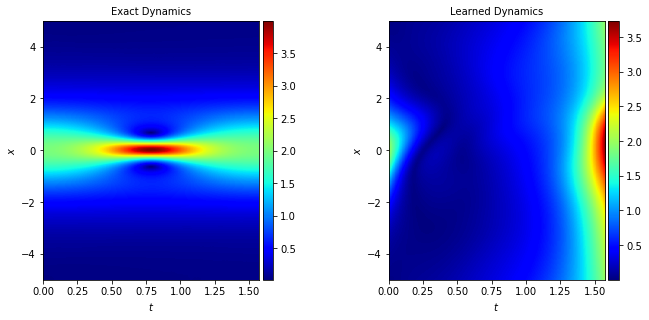

In [24]:
######################################################################
    ############################# Plotting ###############################
    ######################################################################    
    
#fig, ax = newfig(1.0, 0.6)

#fig, ax = plt.figure()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

ax.axis('off')
    
######## Row 2: Pressure #######################
########      Predicted p(t,x,y)     ########### 
gs = gridspec.GridSpec(1, 2)
gs.update(top=0.8, bottom=0.2, left=0.1, right=0.9, wspace=0.5)
ax = plt.subplot(gs[:, 0])
h = ax.imshow(Exact_uv_sol, interpolation='nearest', cmap='jet', 
              extent=[lb_sol[0], ub_sol[0], lb_sol[1], ub_sol[1]],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Exact Dynamics', fontsize = 10)
    
########     Exact p(t,x,y)     ########### 
ax = plt.subplot(gs[:, 1])
h = ax.imshow(UV_pred, interpolation='nearest', cmap='jet', 
              extent=[lb_sol[0], ub_sol[0], lb_sol[1], ub_sol[1]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Learned Dynamics', fontsize = 10)
fig.show()
   
# savefig('./figures/NLS')